In [1]:
!pip show keras

Name: Keras
Version: 2.2.4
Summary: Deep Learning for humans
Home-page: https://github.com/keras-team/keras
Author: Francois Chollet
Author-email: francois.chollet@gmail.com
License: MIT
Location: c:\users\1\miniconda3\lib\site-packages
Requires: numpy, scipy, six, pyyaml, h5py, keras-applications, keras-preprocessing
Required-by: 


In [2]:
!pip freeze > requirements.txt

In [1]:
import random
import numpy as np
import pandas as pd
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, BatchNormalization
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
%matplotlib inline

Using TensorFlow backend.


In [2]:
# seed values
SEED = 42
random.seed = SEED
np.random.seed(seed=SEED)

In [7]:
# MODEL
BATCH_SIZE  = 512
EPOCH       = 40
LR          = 10**-5
VAL_SPLIT   = 0.25  #15%

# TOKENIZER
# The maximum number of words to be used. (most frequent)
MAX_WORDS = 20000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 100

DATA_PATH = './input/'

# Data
#### TRAIN

In [8]:
train_df = pd.read_csv(DATA_PATH+'train.csv',)

In [9]:
train_df.head()

,name,genre,text
0,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
1,Cupid (1997),thriller,A brother and sister with a past incestuous r...
2,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
3,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
4,The Unrecovered (2007),drama,The film's title refers not only to the un-re...


In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54214 entries, 0 to 54213
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    54214 non-null  object
 1   genre   54214 non-null  object
 2   text    54214 non-null  object
dtypes: object(3)
memory usage: 1.2+ MB


Text(0, 0.5, 'Counts')

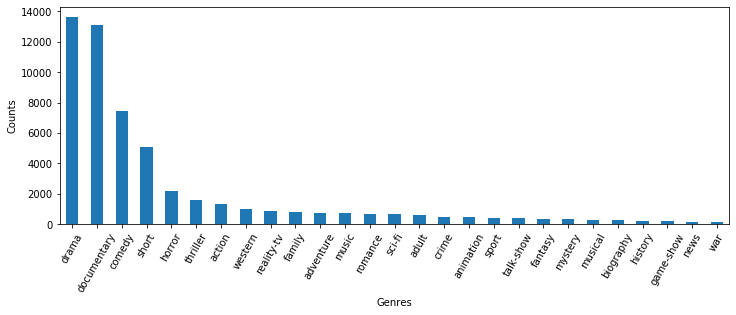

In [11]:
train_df.genre.value_counts().plot(kind='bar',figsize=(12,4),fontsize=10)
plt.xticks(rotation=60)
plt.xlabel("Genres",fontsize=10)
plt.ylabel("Counts",fontsize=10)

### TEST

In [12]:
test_df = pd.read_csv(DATA_PATH+'test.csv')
test_df.head()

,name,text
0,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apar..."
1,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty ch..."
2,Off the Beaten Track (2010),One year in the life of Albin and his family ...
3,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with hi..."
4,Er nu zhai (1955),Before he was known internationally as a mart...


### Target

In [13]:
Y = pd.get_dummies(train_df.genre)
CLASS_NUM = Y.shape[1]
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (54214, 27)


In [14]:
Y.head()

,action,adult,adventure,animation,biography,comedy,crime,documentary,drama,family,...,news,reality-tv,romance,sci-fi,short,sport,talk-show,thriller,war,western
0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


# Preprocessing

### Clean Data

In [15]:
import tensorflow as tf
import keras.backend as K
# чистит сессию в Keras и TF
def reset_tf_session():
    curr_session = tf.get_default_session()
    # close current session
    if curr_session is not None:
        curr_session.close()
    # reset graph
    K.clear_session()
    # create new session
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    s = tf.InteractiveSession(config=config)
    K.set_session(s)
    return s
s = reset_tf_session()
# данные у нас и так достаточно чистые

In [16]:
# для построения словаря мы используем весь текст
all_text = train_df.text.append(test_df.text, ignore_index=True)
all_names = train_df.name

In [17]:
%%time
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize1 = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(all_text)
tokenize1.fit_on_texts(all_names)

Wall time: 10.5 s


теперь переведем наш текст в вектор

In [18]:
%%time
sequences = tokenize.texts_to_sequences(train_df.text)
name_sequences = tokenize.texts_to_sequences(train_df.name)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=MAX_SEQUENCE_LENGTH)
name_sequences_matrix = sequence.pad_sequences(name_sequences,maxlen=MAX_SEQUENCE_LENGTH)
print(sequences_matrix.shape)

(54214, 100)
Wall time: 4.66 s


In [19]:
# вот так теперь выглядит наш текст
print(train_df.text[1])
print(sequences_matrix[1])

 A brother and sister with a past incestuous relationship have a current murderous relationship. He murders the women who reject him and she murders the women who get too close to him.
[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     3   194     2   255
     9     3   162 13276   201    41     3   906  4142   201    11  1493
     1   135    20 10246    32     2    22  1493     1   135    20    69
   258   424     5    32]


# Model
Архитектура сети достаточно простая. Попробуйте самостоятельно поиграться с гиперпараметрами сети и составом слоев. 


In [20]:
def RNN():
    inputs1 = Input(name='inputs1',shape=[MAX_SEQUENCE_LENGTH])
    layer1 = Embedding(MAX_WORDS,50,input_length=MAX_SEQUENCE_LENGTH)(inputs1)
    layer1 = LSTM(100)(layer1)
    inputs2 = Input(name='inputs2',shape=[MAX_SEQUENCE_LENGTH])
    layer2 = Embedding(MAX_WORDS,50,input_length=MAX_SEQUENCE_LENGTH)(inputs2)
    layer2 = LSTM(100)(layer2)
    layer = keras.layers.Add()([layer1,layer2])
    layer = BatchNormalization()(layer)
    layer = Dense(256, activation='relu', name='FC1')(layer)
    layer = Dropout(0.5)(layer)
    layer = BatchNormalization()(layer)
    layer = Dense(100, activation='relu', name='FC2')(layer)
    layer = Dropout(0.5)(layer)
    layer = BatchNormalization()(layer)
    layer = Dense(CLASS_NUM, activation='softmax', name='out_layer')(layer)
    model = Model(inputs=[inputs1,inputs2],outputs=layer)
    return model

In [21]:
def Sheduler(epoch,learning_rate):
    return max((-abs(epoch-EPOCH/2)+EPOCH/2)/EPOCH*2*LR*4,LR*4/10)

In [37]:
import keras
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
# Рекомендую добавть еще функции из https://keras.io/callbacks/
shedul=LearningRateScheduler(Sheduler)
checkpoint = ModelCheckpoint('best_model.hdf5' , monitor = ['val_acc'] , verbose = 1  , mode = 'max')
callbacks_list = [shedul,checkpoint]

In [22]:
model = RNN()
model.summary()
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(lr=LR), metrics=['accuracy'])



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs1 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
inputs2 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 100, 50)      1000000     inputs1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 100, 50)      1000000     inputs2[0][0]             

In [38]:
history = model.fit([sequences_matrix,name_sequences_matrix],Y,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCH,
                    validation_split=VAL_SPLIT,callbacks = callbacks_list)

Train on 40660 samples, validate on 13554 samples
Epoch 1/40
40660/40660 [==============================] - 20s 488us/step - loss: 0.0188 - acc: 0.9966 - val_loss: 4.7592 - val_acc: 0.4326

Epoch 00001: saving model to best_model.hdf5
Epoch 2/40
40660/40660 [==============================] - 19s 471us/step - loss: 0.0186 - acc: 0.9967 - val_loss: 4.7683 - val_acc: 0.4316

Epoch 00002: saving model to best_model.hdf5
Epoch 3/40
40660/40660 [==============================] - 19s 467us/step - loss: 0.0181 - acc: 0.9970 - val_loss: 4.7783 - val_acc: 0.4290

Epoch 00003: saving model to best_model.hdf5
Epoch 4/40
40660/40660 [==============================] - 19s 469us/step - loss: 0.0188 - acc: 0.9966 - val_loss: 4.7692 - val_acc: 0.4338

Epoch 00004: saving model to best_model.hdf5
Epoch 5/40
40660/40660 [==============================] - 19s 472us/step - loss: 0.0190 - acc: 0.9964 - val_loss: 4.7826 - val_acc: 0.4324

Epoch 00005: saving model to best_model.hdf5
Epoch 6/40
40660/40660 [=

In [42]:
model.save('keras_nlp_lstm.h5')

In [23]:
model.load_weights('keras_nlp_lstm.h5')

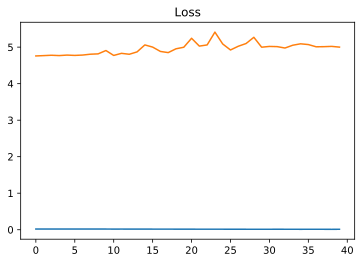

In [40]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.savefig('1.png')
plt.show()

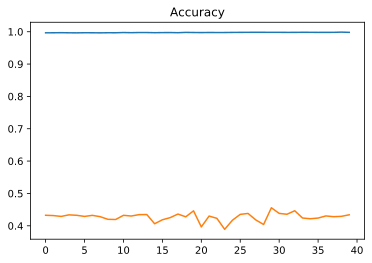

In [41]:
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.savefig('1.png')
plt.show()


# Submission

In [69]:
test_sequences = tokenize.texts_to_sequences(test_df.text)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=MAX_SEQUENCE_LENGTH)

In [70]:
%%time
predict_proba = model.predict(test_sequences_matrix)

Wall time: 2min 16s


In [71]:
# на соревнованиях всегда сохраняйте predict_proba, чтоб потом можно было построить ансамбль решений
predict_proba = pd.DataFrame(predict_proba, columns=Y.columns)
predict_proba.to_csv('predict_proba.csv', index=False)
predict_proba.head()

,action,adult,adventure,animation,biography,comedy,crime,documentary,drama,family,...,news,reality-tv,romance,sci-fi,short,sport,talk-show,thriller,war,western
0,7.058830e-03,3.251071e-04,4.750835e-04,1.727422e-04,0.000223,2.693187e-04,1.061103e-02,7.450052e-06,7.952644e-01,2.185898e-04,...,3.457841e-05,2.118442e-05,1.193285e-02,8.621697e-04,0.000558,6.841982e-05,3.233160e-05,1.228970e-01,0.000443,0.000728
1,6.913097e-06,1.616333e-06,6.433077e-07,2.474341e-07,0.000009,5.230836e-06,2.506411e-05,2.945576e-06,9.972711e-01,5.244132e-06,...,6.882689e-07,2.523999e-08,1.685672e-03,6.777734e-07,0.000003,5.942785e-07,5.763779e-07,8.744827e-04,0.000015,0.000003
2,6.028661e-09,1.240044e-07,2.916683e-07,1.379803e-07,0.001026,3.250780e-09,1.948554e-07,9.975138e-01,7.060814e-07,7.550856e-07,...,3.115492e-05,1.519421e-05,1.040536e-07,7.928926e-07,0.000804,5.363755e-06,9.027840e-06,6.034772e-08,0.000010,0.000001
3,1.586952e-04,2.175560e-05,5.329810e-05,2.086326e-05,0.000041,1.726648e-04,7.118233e-04,3.258175e-05,9.860415e-01,2.512234e-04,...,1.212938e-05,5.020025e-06,1.580570e-03,2.774195e-05,0.004264,6.907203e-06,1.095272e-05,5.227433e-03,0.000075,0.000023
4,1.259998e-04,1.172450e-05,4.368821e-06,2.417277e-06,0.000009,4.056920e-04,2.309589e-04,1.330171e-07,9.729860e-01,1.945154e-04,...,1.585434e-06,2.755962e-07,1.834171e-02,6.481851e-06,0.000028,1.486612e-06,1.078400e-06,6.734530e-03,0.000029,0.000034


In [72]:
predict_genre = Y.columns[np.argmax(predict_proba.values, axis=1)]

In [73]:
submission = pd.DataFrame({'id':range(1, len(predict_genre)+1), 
                           'genre':predict_genre}, 
                          columns=['id', 'genre'])

submission.to_csv('submission.csv', index=False)
submission.head()

,id,genre
0,1,drama
1,2,drama
2,3,documentary
3,4,drama
4,5,drama


Готово!

## Что можно сделать, чтоб улучшить результат:
* Подобрать LR, optimizer, loss
* Поиграться с архитектурой
* Подобрать другие переменные (MAX_WORDS, MAX_SEQUENCE_LENGTH, батч и тп)
* Добавить политику обучения
* Добавить в обучение название фильма (для pro: попробуйте это сделать через concatenate слой)
* Попробовать уже предобученные Векторизаторы (GLOVE, W2V и тд)
* Попробовать уже предобученные модели (BERT, TRANFORMER и тд)
* Построить ансамбль из разных архитектур

### Удачи в соревновании!